In [232]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer,confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

plt.style.use('ggplot')

import sys
sys.path.append("../")
#from src.clean_churn_data import clean_churn_data
from src.helper import clean_churn_data
from src.helper import accuracy_scores
from src.helper import plot_roc_curve
from src.confusion_df import render_mpl_table
from src.confusion_df import confusion_df

In [233]:
df=pd.read_csv('../data/churn_train.csv')

In [234]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [235]:
df=clean_churn_data(df)

In [236]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,city: Astapor,city: King's Landing,city: Winterfell,churn?
0,6.94,5.0,5.000000,1.00,0,0.0,0,0,100.0,1,0,0,1
1,8.06,5.0,5.000000,1.00,0,0.0,2,1,0.0,1,0,0,1
2,21.50,4.0,4.601697,1.00,1,0.0,1,1,100.0,0,0,1,1
3,9.46,5.0,4.601697,2.75,0,100.0,1,0,100.0,0,0,1,1
4,13.77,5.0,4.601697,1.00,1,0.0,0,0,100.0,0,0,1,1


In [237]:
y = df['churn?']

In [238]:
X = df.drop('churn?',axis=1)

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [240]:
# Train and fit model                                                   
rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)

In [241]:
#print(f"log loss : {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
#print(f"accuracy : {rf.score(X_test, y_test)}")
#print(f"confusion matrix : \n{confusion_matrix(y_test, pred)}")
#print("precision :", precision_score(y_test, pred))
#print("recall (probability of detection):", recall_score(y_test, pred))

In [242]:
data=confusion_df(y_test, pred)

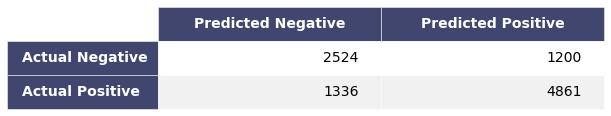

In [243]:
fig, ax = render_mpl_table(data)

In [244]:
fig.savefig('../img/rf_cm1.png', bbox_inches='tight')
fig.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


In [245]:
accuracy, recall, precision, mse = accuracy_scores(y_test, pred)

In [246]:
print(f"accuracy : {accuracy}")
print(f"recall : {recall}")
print(f"precision : {precision}")
print(f"mse : {mse}")

accuracy : 0.744
recall : 0.784
precision : 0.802
mse : 0.256


In [247]:
# get the feature importances
feature_importances = np.argsort(rf.feature_importances_)
print("top five:", list(df.columns[feature_importances[-1:-6:-1]]))

top five: ['avg_dist', 'weekday_pct', 'avg_rating_by_driver', 'surge_pct', 'avg_rating_of_driver']



 Feature ranking: 

1. avg_dist (0.295497)
2. weekday_pct (0.126593)
3. avg_rating_by_driver (0.117015)
4. surge_pct (0.105922)
5. avg_rating_of_driver (0.083049)
6. trips_in_first_30_days (0.080423)
7. avg_surge (0.043523)
8. phone (0.038656)
9. luxury_car_user (0.031212)
10. city: Astapor (0.016394)


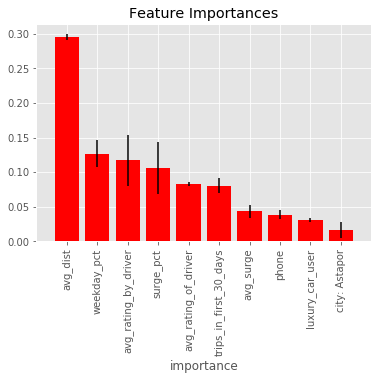

In [248]:
# Calculate the standard deviation for feature importances across all trees

n = 10 # top 10 features

#importances = forest_fit.feature_importances_[:n]
importances = rf.feature_importances_[:n]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(df.columns[indices])

# Print the feature ranking
print("\n Feature ranking: \n")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig, ax = plt.subplots()

ax.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(features, rotation = 90)
ax.set_xlim([-1, 10])
ax.set_xlabel("importance")
ax.set_title("Feature Importances")
fig.savefig('../img/rf_feature_importance.png', bbox_inches='tight')

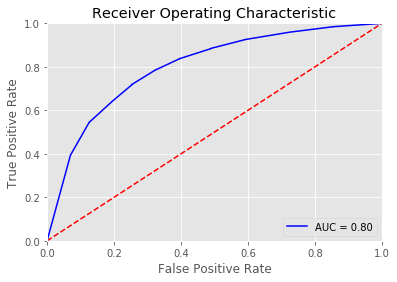

In [249]:

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [196]:
probs[:,1]

array([0.2218523 , 0.42339519, 0.10707311, ..., 0.491167  , 0.1370501 ,
       0.85693835])

In [197]:
probs

array([[0.7781477 , 0.2218523 ],
       [0.57660481, 0.42339519],
       [0.89292689, 0.10707311],
       ...,
       [0.508833  , 0.491167  ],
       [0.8629499 , 0.1370501 ],
       [0.14306165, 0.85693835]])

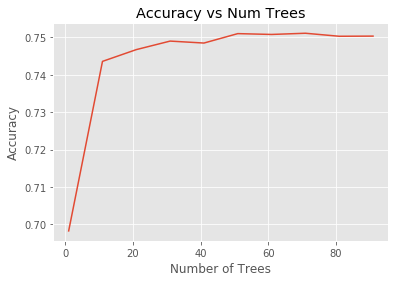

In [178]:
# modifying the number of trees
num_trees = range(1, 100, 10)
accuracies = []
for n in num_trees:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_trees, accuracies)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Trees')
fig.savefig('../img/rf_num_tree.png', bbox_inches='tight')
#max values starting from n_estimators=40 trees

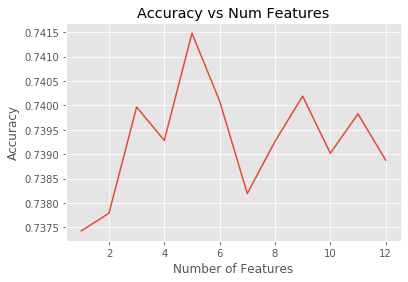

In [179]:
# modifying the max features parameter

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

num_features = range(1, len(df.columns))
accuracies = []
for n in num_features:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(max_features=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_features, accuracies)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Features');
fig.savefig('../img/rf_num_features.png', bbox_inches='tight')
# maximum at 5 and 9 features

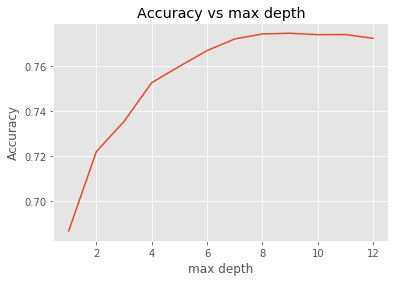

In [180]:
# modifying the max_depth

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

num_features = range(1, len(df.columns))
accuracies = []
for n in num_features:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(max_depth=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_features, accuracies)
ax.set_xlabel("max depth")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs max depth');
fig.savefig('../img/rf_tree_depth.png', bbox_inches='tight')
# maximum at max_depth of 10

In [250]:
# Train and fit model (max_depth=10)                                                  
rf = RandomForestClassifier(n_estimators=40,
                           max_features=5,
                           max_depth=10,
                            random_state=0)
model = rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss : {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy : {rf.score(X_test, y_test)}")
print(f"confusion matrix : \n{confusion_matrix(y_test, pred)}")

print("precision :", precision_score(y_test, pred))
print("recall (probability of detection):", recall_score(y_test, pred))

log loss : 0.4573521035879
accuracy : 0.7916540671303296
confusion matrix : 
[[2477 1247]
 [ 820 5377]]
precision : 0.8117451690821256
recall (probability of detection): 0.8676779086654833


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


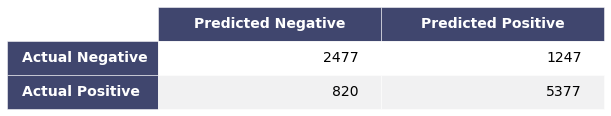

In [251]:
data=confusion_df(y_test, pred)
fig, ax = render_mpl_table(data)
fig.savefig('../img/rf_cm2.png', bbox_inches='tight')
fig.show()

In [252]:
probs = model.predict_proba(X_test)
preds = probs[:,1]

In [253]:
np.savetxt('../data/rf_y_hat.txt', preds)
np.savetxt('../data/rf_y_test.txt', y_test)

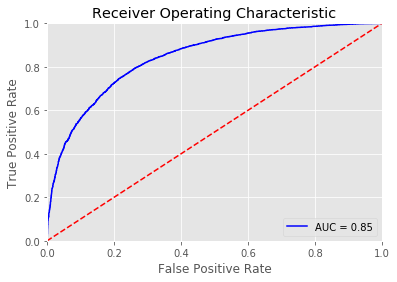

In [184]:

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('../img/rf_roc.png', bbox_inches='tight')
plt.show()

In [185]:
plt.savefig('../img/rf_roc.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [276]:
importances = rf.feature_importances_


#indices = np.argsort(importances)[::-1]
features = list(df.drop(columns='churn?').columns)

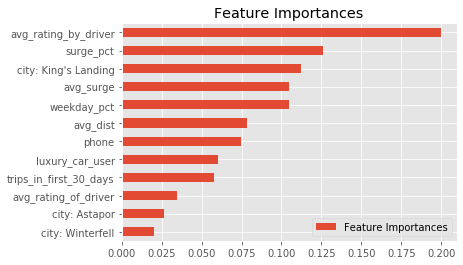

In [277]:
# Feature Importances
importances = pd.DataFrame({'Feature Importances': importances},
                       index=features)
importances = importances.sort_values(by='Feature Importances')
importances.plot(kind='barh')
plt.title("Feature Importances")
plt.savefig('../img/rf_feature_importance.png', bbox_inches='tight')